# ML Deployment: Train, evaluate, and serve a TensorFlow model

**Credit:** This tutorial is sourced from the Tensorflow Rest-Simple Model Serving Tutorial (Source:  https://www.tensorflow.org/tfx/tutorials/serving/rest_simple). Modifications to the tutorial are noted below.

## Load dependencies and helper functions

In [1]:
#Source:  https://www.tensorflow.org/tfx/tutorials/serving/rest_simple

import sys
# TensorFlow and tf.keras
!pip install -Uq grpcio==1.26.0

import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

print('TensorFlow version: {}'.format(tf.__version__))

     |████████████████████████████████| 2.4 MB 3.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
TensorFlow version: 2.8.0


In [2]:
#Source: https://github.com/cmasch/zalando-fashion-mnist/blob/master/Simple_Convolutional_Neural_Network_Fashion-MNIST.ipynb

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, class_, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function plots a confusion matrix
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(class_))
    plt.xticks(tick_marks, class_, rotation=90)
    plt.yticks(tick_marks, class_)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()

## Load the Fashion-MNIST dataset

In [3]:
#Source:  https://www.tensorflow.org/tfx/tutorials/serving/rest_simple

#Load the fashion_mnist dataset with the train/test split
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4431872/4422102 [==============================] - 0s 0us/step

train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


Text(0.5, 1.0, 'Ankle boot')

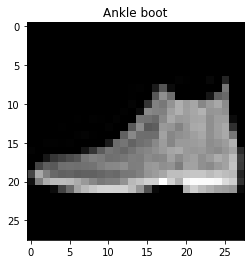

In [4]:
plt.imshow(np.reshape(test_images[0], (28,28)), cmap=plt.cm.gray)
plt.title(class_names[test_labels[0]])

In [5]:
unique, counts = np.unique(train_labels, return_counts=True)
print("Images per class: ")

dict(zip(unique, counts))

Images per class: 


{0: 6000,
 1: 6000,
 2: 6000,
 3: 6000,
 4: 6000,
 5: 6000,
 6: 6000,
 7: 6000,
 8: 6000,
 9: 6000}

## Train a simple CNN model

In [6]:
#Source:  https://www.tensorflow.org/tfx/tutorials/serving/rest_simple

model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, name='Dense')
])
model.summary()

epochs = 5

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=epochs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 13, 13, 8)         80        
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 Dense (Dense)               (None, 10)                13530     
                                                                 
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1875/1875 [==============================] - 17s 3ms/step - loss: 0.5621 - sparse_categorical_accuracy: 0.8031
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4216 - sparse_categorical_accuracy: 0.8527
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 

### Measure the performance of your model

#### CPU time (does not provide the full picture!)

In [7]:
%%time
train_loss, train_acc = model.evaluate(train_images, train_labels)
print('\nTrain accuracy: {}'.format(train_acc))

1875/1875 [==============================] - 6s 3ms/step - loss: 0.3092 - sparse_categorical_accuracy: 0.8892

Train accuracy: 0.88919997215271
CPU times: user 5.59 s, sys: 896 ms, total: 6.49 s
Wall time: 5.9 s


In [8]:
%%time
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

313/313 [==============================] - 2s 6ms/step - loss: 0.3521 - sparse_categorical_accuracy: 0.8738

Test accuracy: 0.8737999796867371
CPU times: user 1.85 s, sys: 169 ms, total: 2.02 s
Wall time: 2.91 s


#### Confusion Matrices

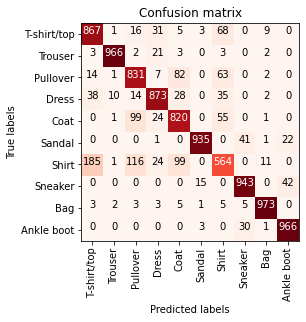

In [9]:
predictions = model.predict(test_images, verbose=0)
classes_x=np.argmax(predictions,axis=1)
plot_confusion_matrix(confusion_matrix(test_labels, classes_x), class_names)

#### Preliminary robustness analysis

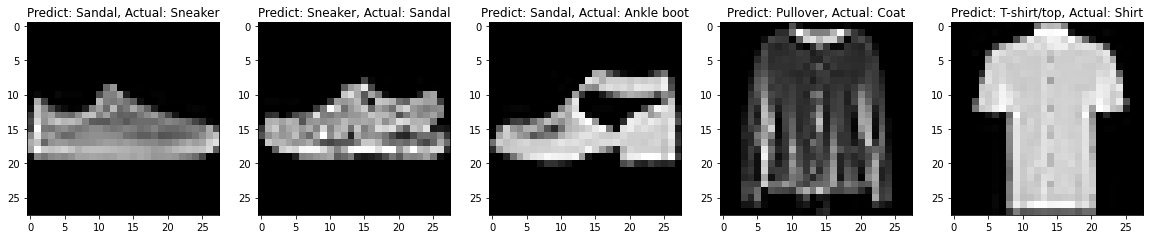

In [10]:
#Pull out 5 misidentified imags to identify what the model is mis-predicting
#Modified from https://stackoverflow.com/questions/61980660/display-misclassified-digits-from-confusion-matrix
mispredicted_imgs = np.where(test_labels!=classes_x)[0]
plt.figure(figsize=(20,20))
for plt_idx, misclassified_idx in enumerate(mispredicted_imgs[0:5]):
    plt.subplot(1, 5, plt_idx + 1)
    plt.imshow(np.reshape(test_images[misclassified_idx], (28,28)), cmap=plt.cm.gray)
    plt.title('Predict: {}, Actual: {}'.format(class_names[classes_x[misclassified_idx]], class_names[test_labels[misclassified_idx]]),
              fontsize = 12)

## Save your model

To load our trained model into TensorFlow Serving we first need to save it in [SavedModel](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/saved_model) format.  This will create a protobuf file in a well-defined directory hierarchy, and will include a version number.  [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) allows us to select which version of a model, or "servable" we want to use when we make inference requests.  Each version will be exported to a different sub-directory under the given path.

In [11]:
#Source:  https://www.tensorflow.org/tfx/tutorials/serving/rest_simple
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1



INFO:tensorflow:Assets written to: /tmp/1/assets


INFO:tensorflow:Assets written to: /tmp/1/assets



Saved model:
total 92
drwxr-xr-x 2 root root  4096 Feb 27 05:14 assets
-rw-r--r-- 1 root root  8228 Feb 27 05:14 keras_metadata.pb
-rw-r--r-- 1 root root 72310 Feb 27 05:14 saved_model.pb
drwxr-xr-x 2 root root  4096 Feb 27 05:14 variables


## Examine your saved model

We'll use the command line utility `saved_model_cli` to look at the [MetaGraphDefs](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef) (the models) and [SignatureDefs](../signature_defs) (the methods you can call) in our SavedModel.  See [this discussion of the SavedModel CLI](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/saved_model.md#cli-to-inspect-and-execute-savedmodel) in the TensorFlow Guide.

In [12]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Dense'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          inputs: Ten

That tells us a lot about our model!  In this case we just trained our model, so we already know the inputs and outputs, but if we didn't this would be important information.  It doesn't tell us everything, like the fact that this is grayscale image data for example, but it's a great start.

## Serve your model with TensorFlow Serving

**Warning: If you are running this NOT on a Google Colab,** following cells
will install packages on the system with root access. If you want to run it in
a local Jupyter notebook, please proceed with caution.

### Add TensorFlow Serving distribution URI as a package source:

We're preparing to install TensorFlow Serving using [Aptitude](https://wiki.debian.org/Aptitude) since this Colab runs in a Debian environment.  We'll add the `tensorflow-model-server` package to the list of packages that Aptitude knows about.  Note that we're running as root.

Note: This example is running TensorFlow Serving natively, but [you can also run it in a Docker container](https://www.tensorflow.org/tfx/serving/docker), which is one of the easiest ways to get started using TensorFlow Serving.

In [13]:
#Source:  https://www.tensorflow.org/tfx/tutorials/serving/rest_simple
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [14]:
#Source:  https://www.tensorflow.org/tfx/tutorials/serving/rest_simple
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  14863      0 --:--:-- --:--:-- --:--:-- 14863
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server-universal amd64 Packages [349 B]
Ign:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:8 http://storage.googleapis.c

### Install TensorFlow Serving

In [15]:
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 69 not upgraded.
Need to get 340 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.8.0 [340 MB]
Fetched 340 MB in 8s (42.3 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 155320 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.8.0_all.deb ...
Unpacking tensorflow-model-server (2.8.0) ...
Setting up tensorflow-model-server (2.8.0) ...


### Start running TensorFlow Serving

In [16]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [17]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


Starting job # 0 in a separate thread.


In [18]:
!tail server.log

## Make a request to your model in TensorFlow Serving

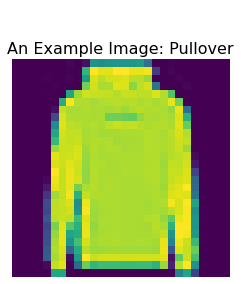

In [19]:
#Source:  https://www.tensorflow.org/tfx/tutorials/serving/rest_simple

def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

In [20]:
#Source:  https://www.tensorflow.org/tfx/tutorials/serving/rest_simple

import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


### Make REST requests

#### Newest version of the servable

We'll send a predict request as a POST to our server's REST endpoint, and pass it three examples.  We'll ask our server to give us the latest version of our servable by not specifying a particular version.

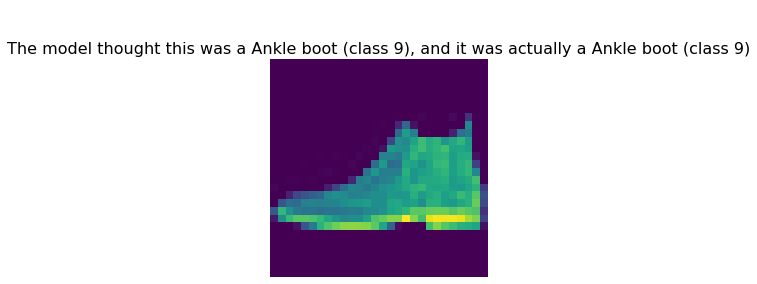

In [21]:
#Source:  https://www.tensorflow.org/tfx/tutorials/serving/rest_simple
# docs_infra: no_execute
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))

#### A particular version of the servable

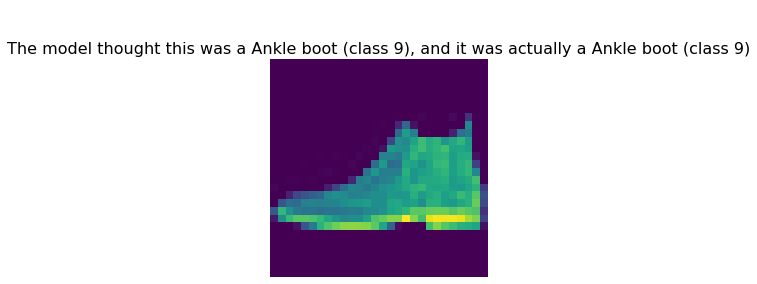

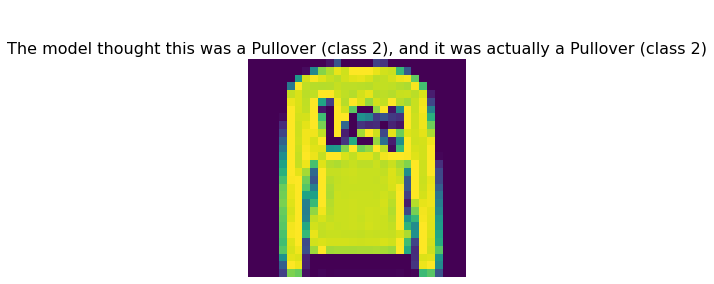

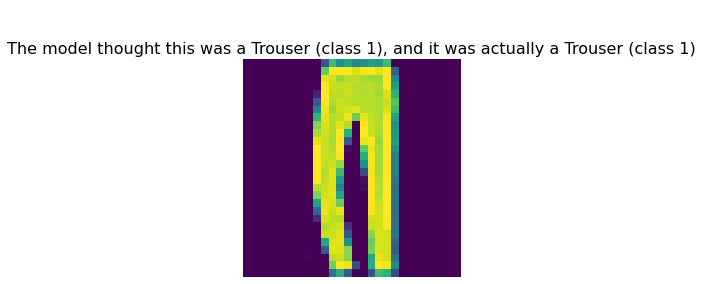

In [22]:
#Source:  https://www.tensorflow.org/tfx/tutorials/serving/rest_simple

# docs_infra: no_execute
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))